## **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. Hence as an example for 2 students:
12301230_3434343_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [ ]:
NAME = "Blazej Manczak"
NAME2 = "Arsen Sheverdin"
EMAIL = "blazej.manczak@student.uva.nl"
EMAIL2 = "arsen.sheverdin@student.uva.nl"

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2020

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [4]:
def gen_sine(n):
    x = np.linspace(0, 2*np.pi, n) # 2*np.pi
    t = np.random.normal(np.sin(x), 0.25)
    return x, t


In [5]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



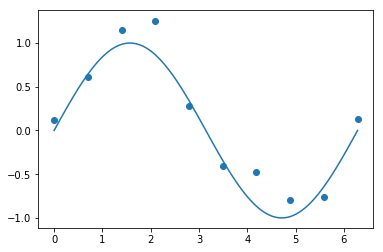

In [6]:
n = 100
x_t = np.linspace(0, 2*np.pi, n)
t_t = np.sin(x_t)

plt.scatter(x,t)
plt.plot(x_t, t_t)

### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [7]:
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 3

In [8]:
stack = np.repeat(x,m+1).reshape(x.shape[0], m+1)
np.power(stack, range(0,m+1))


array([[ 1.        , -1.        ,  1.        , -1.        ],
       [ 1.        , -0.77777778,  0.60493827, -0.47050754],
       [ 1.        , -0.55555556,  0.30864198, -0.17146776],
       [ 1.        , -0.33333333,  0.11111111, -0.03703704],
       [ 1.        , -0.11111111,  0.01234568, -0.00137174],
       [ 1.        ,  0.11111111,  0.01234568,  0.00137174],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.55555556,  0.30864198,  0.17146776],
       [ 1.        ,  0.77777778,  0.60493827,  0.47050754],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [9]:
np.repeat(x,m+1).reshape(x.shape[0], m+1)

array([[-1.        , -1.        , -1.        , -1.        ],
       [-0.77777778, -0.77777778, -0.77777778, -0.77777778],
       [-0.55555556, -0.55555556, -0.55555556, -0.55555556],
       [-0.33333333, -0.33333333, -0.33333333, -0.33333333],
       [-0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [ 0.11111111,  0.11111111,  0.11111111,  0.11111111],
       [ 0.33333333,  0.33333333,  0.33333333,  0.33333333],
       [ 0.55555556,  0.55555556,  0.55555556,  0.55555556],
       [ 0.77777778,  0.77777778,  0.77777778,  0.77777778],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [10]:
from scipy import linalg

def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    "Returns an x.shape[0] by M+1 design matrix corresponding to M-th order polynomial"
    stack = np.repeat(x,M+1).reshape(x.shape[0], M+1) # preparing the matrix to apply consecutive powers from 0 up to M (inclusive)
    Phi = np.power(stack, range(0,M+1)) 
    return Phi

def fit_polynomial(x, t, M):
    Phi = designmatrix(x, M)
    w_ml = (linalg.inv(Phi.T@Phi))@Phi.T@t
    return w_ml, Phi


In [11]:
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)
w, Phi

(array([  2.50000000e+00,  -1.11022302e-16,   3.00000000e-01]),
 array([[ 1.        , -1.        ,  1.        ],
        [ 1.        , -0.77777778,  0.60493827],
        [ 1.        , -0.55555556,  0.30864198],
        [ 1.        , -0.33333333,  0.11111111],
        [ 1.        , -0.11111111,  0.01234568],
        [ 1.        ,  0.11111111,  0.01234568],
        [ 1.        ,  0.33333333,  0.11111111],
        [ 1.        ,  0.55555556,  0.30864198],
        [ 1.        ,  0.77777778,  0.60493827],
        [ 1.        ,  1.        ,  1.        ]]))

In [12]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



In [13]:
print("Prediction format:", np.sum(w*Phi, axis = 1))

Prediction format: [ 2.8         2.68148148  2.59259259  2.53333333  2.5037037   2.5037037
  2.53333333  2.59259259  2.68148148  2.8       ]


### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

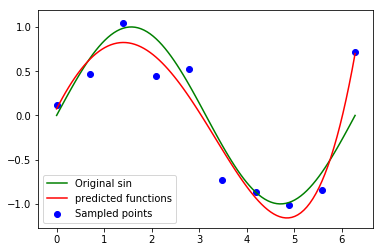

In [14]:
from matplotlib import pyplot as plt
import random 

np.random.seed(12)

N = 10

x_true = np.linspace(0, 2*np.pi, 100) # many more observations to create a smooth sin
t_true = np.sin(x_true)

x, t = gen_sine(N)

M = [0,2,4,8]
i = 2
Phi_true = designmatrix(x_true, M[i])

w, Phi = fit_polynomial(x,t,M[i])

plt.plot(x_true,t_true, color = "green", label = "Original sin")
plt.scatter(x,t, color = "blue", label = "Sampled points")
#plt.scatter(x, np.sum(w*Phi, axis = 1), color = "red", label = "Predictions")
plt.plot(x_true, np.sum(w*Phi_true, axis = 1), color = "red", label = "predicted functions" )

plt.legend()

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [15]:
def fit_polynomial_reg(x, t, M, lamb):
    Phi = designmatrix(x, M)
    w_ml = (linalg.inv(np.identity(M+1)*lamb + Phi.T@Phi))@Phi.T@t #formula from page 144
    return w_ml, Phi


In [16]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

In [17]:
N = 10
x = np.linspace(-2, 2, N)
t = 0.3*np.power(x,2) + 2.5
m = 3
lamb = 0.5

w, Phi = fit_polynomial(x,t,m)
w_reg, Phi_reg = fit_polynomial_reg(x,t,m, lamb)

print("Non regularized weights: {0} \nRegularized weights:{1}".format(w, w_reg))

Non regularized weights: [  2.50000000e+00   1.38777878e-16   3.00000000e-01  -8.32667268e-17] 
Regularized weights:[  2.25673967e+00  -5.55111512e-17   3.80032505e-01  -1.28369537e-16]


In [18]:
Phi == Phi_reg

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]], dtype=bool)

## Answer: 
Weights in regularized case are smaller (not that much). Nothing happens to Phi






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [19]:
def pred_error(x_train, x_valid, t_train, t_valid, M, lamb):
    
    w_reg, _ = fit_polynomial_reg(x_train,t_train,M, lamb) # get estimates of w
    Phi_valid = designmatrix(x_valid, M) # get the Phi matrix for validation data
    
    preds_valid = np.sum(w_reg*Phi_valid, axis= 1)
    pred_err = np.average(np.power(t_valid - preds_valid,2))
    
    return pred_err


In [20]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [21]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [22]:
inds = kfold_indices(100, 5)

for train, valid in zip(inds[0], inds[1]):
    print(len(train), len(valid))

80 20
80 20
80 20
80 20
80 20


In [23]:
def find_best_m_and_lamb(x, t, k, M = range(0,10), Reg = [np.exp(-i) for i in range(0,10)] ):
    """
    Input:
        x: input data, array
        t: target values, array 
        k: number of folds
        M: iterable, search domain of M
        Reg: iterable, search domain for lambda
    """
    inds = kfold_indices(x.shape[0], k)
    errors = {} # storing erros in a [m, lamb](key), [errors](value pairs)
    for m in M: # iterate over M
        for lamb in Reg: # iterate over possible lambdas
            preds = 0 # used to calculate the average error across folds
            for train, valid in zip(inds[0], inds[1]): # iterate over train/validation splits in each fold
                preds += pred_error(x[train], x[valid], t[train], t[valid], m, lamb)
            errors[(m, lamb)] = preds/k # store the average prediction error in the dictionary
    
    opt = min(errors, key=errors.get)
    print(print("The optimal values for m and lambda are {} and {} respecitvely.\nThey result in an error {}".format(opt[0], opt[1], errors[opt])))
    M_best, lamb_best = opt[0], opt[1]
    
    return M_best, lamb_best


In [24]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5

ans = find_best_m_and_lamb(x,t,2)
ans[0], ans[1]

The optimal values for m and lambda are 2 and 0.00012340980408667956 respecitvely.
They result in an error 1.2393912809959596e-08
None


(2, 0.00012340980408667956)

In [25]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

**Answer**: One should not optimize hyperparameters in a sequential way as the hyperparameters often intearct in a non-linear manner. For example, in our case of 2 hyperparameters , the optimal value of one hyperparameter is dependent on the value of the other. 

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

**Answer**: An easy alterantive to grid search is random search. One specify the domian for each of the parameters, number of trials and a cost function to monitor. Then the combinations of parameters are randomly generated and checked against a cost function. This approach implicitly avoids the combinatorial explosion by randomly sampling combinations of parameters. Bergstra & Bengio [1] have shown this approach to work better than grid search for a variety of datasets and algorithms.Anotg

Bayesian hyperparameter optimization[2] is also a quite efficient way of solving this problem. First, probabilistic model for the parameters is initialized (for example gaussian processes model). Then, after one finds the best hyperparameter set that perform well on the model, those parameters are applied to the true objective function (for example, error function). After that, the model is updated with the new data just received and the process repeats itself. This method very efficient in cases when the calls to objective function turn out to be very time or computationally expensive, thus, avoiding the combinatorial explosion seen in grid search.

[1] J. Bergstra, Y. Bengio, Random search for hyper-parameter optimization (2012), Journal of Machine Learning Research.
[2] J. Snoek, H. Larochelle, and R.P. Adams. Practical Bayesian optimization of machine learning algorithms. In Proc. of NIPS’12, 2012.


### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

The optimal values for m and lambda are 3 and 0.049787068367863944 respecitvely.
They result in an error 0.09487860081835578
None


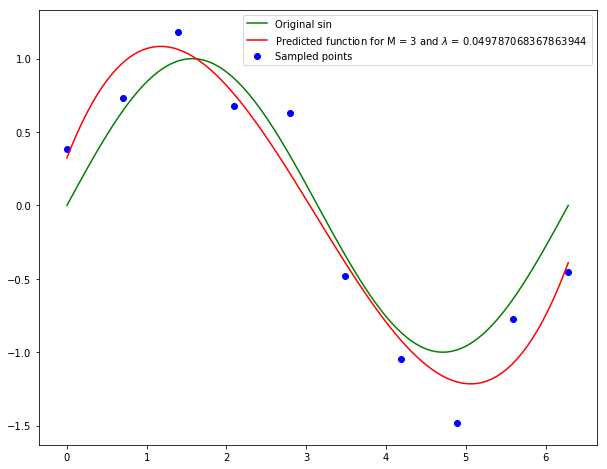

In [26]:
N = 10

np.random.seed(1998)

x_true = np.linspace(0, 2*np.pi, 100) # many more observations to create a smooth sin
t_true = np.sin(x_true)

x, t = gen_sine(N) # generating sin with added noise

ans = find_best_m_and_lamb(x,t,2)
m = ans[0]
lamb = ans[1]
w_reg, _ = fit_polynomial_reg(x,t,m, lamb) # get estimate for w from N data points
Phi_true = designmatrix(x_true, m) # create design matrix for many more data points to create a smooth curve


fig = plt.figure(figsize = (10,8))
plt.plot(x_true,t_true, color = "green", label = "Original sin")
plt.scatter(x,t, color = "blue", label = "Sampled points")
plt.plot(x_true, np.sum(w_reg*Phi_true, axis = 1), color = "red", label = "Predicted function for M = {} and $\lambda$ = {}".format(m,lamb) )


plt.legend()

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [27]:
def gen_sine2(n):
    x = np.sort(np.random.uniform(0, 2*np.pi, n))# 2*np.pi
    t = np.random.normal(np.sin(x), 0.25)
    
    #x,t = sorted(zip(x,t))
    return x, t


In [28]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [29]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    Phi = designmatrix(x, M)
    S = linalg.inv( np.identity(M+1)*alpha + beta*(Phi.T@Phi))
    m = beta*(S@Phi.T@t)
    
    return m, S, Phi


In [30]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [31]:
def predict_polynomial_bayes(x, m, S, beta):
    Phi = designmatrix(x, m.shape[0]-1) # -1 because of the bias
    mean = m.T@Phi.T # each row of Phi corresponds to phi(x)
    #print("Phi shape{}, S shape {}".format(Phi.shape, S.shape))
    sigma = 1/beta + np.array([Phi[i,:]@S@Phi[i,].T for i in range(Phi.shape[0])])
    
    return mean, sigma, Phi


In [32]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


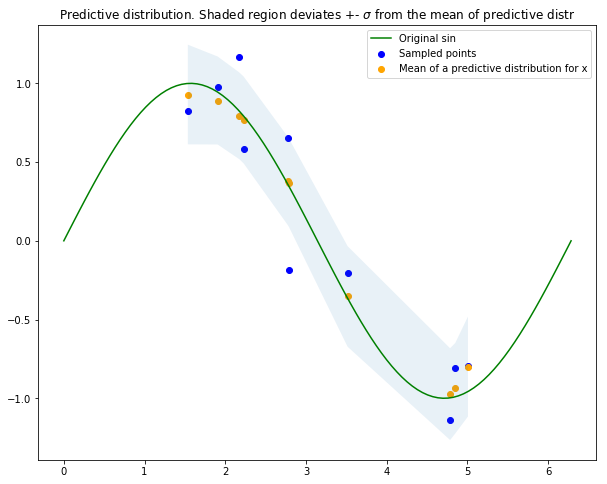

In [33]:
np.random.seed(1998)

x_true = np.linspace(0, 2*np.pi, 100) # many more observations to create a smooth sin
t_true = np.sin(x_true)

N = 10
x, t = gen_sine2(N)
M = 4
alpha = 0.4

beta = np.divide(1, np.power(0.25,2))
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

plt.figure(figsize = (10,8))
plt.plot(x_true,t_true, color = "green", label = "Original sin")
plt.scatter(x,t, color = "blue", label = "Sampled points")
plt.scatter(x, mean, color = "orange", label = "Mean of a predictive distribution for x")
plt.title("Predictive distribution. Shaded region deviates +- $\sigma$ from the mean of predictive distr")
plt.fill_between(x, mean - np.sqrt(sigma), mean+np.sqrt(sigma), alpha = 0.1 )
plt.legend()

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


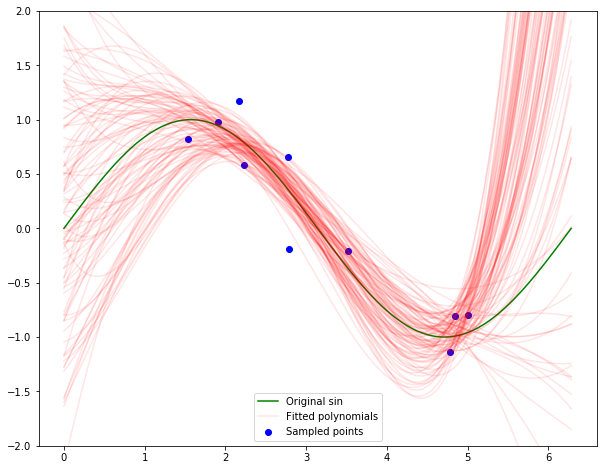

In [34]:
ax = plt.figure(figsize = (10,8))
plt.plot(x_true,t_true, color = "green", label = "Original sin")


for num in range(0,100):
    weights = np.random.multivariate_normal(m, S)
    plt.plot(x_true, np.sum([weight*(x_true**power) for power, weight in enumerate(weights)], axis = 0), color = 'red', alpha = 0.1)
    
plt.plot(x_true, np.sum([weight*(x_true**power) for power, weight in enumerate(weights)], axis = 0), color = 'red', alpha = 0.1, label = "Fitted polynomials")
plt.scatter(x,t, color = "blue", label = "Sampled points")
    
plt.ylim([-2,2])
plt.legend()

In [35]:
weights = np.random.multivariate_normal(m, S)
a = np.array([1,2])
np.sum([weight*(x_true**power) for power, weight in list(enumerate(weights))], axis = 0)

array([-1.3453252 , -1.1949279 , -1.04947433, -0.9090887 , -0.77388588,
       -0.64397141, -0.5194415 , -0.40038301, -0.28687347, -0.17898108,
       -0.07676468,  0.01972621,  0.11045141,  0.19538007,  0.27449069,
        0.3477711 ,  0.41521847,  0.4768393 ,  0.53264944,  0.58267406,
        0.62694769,  0.66551417,  0.6984267 ,  0.7257478 ,  0.74754934,
        0.76391252,  0.77492788,  0.7806953 ,  0.78132399,  0.7769325 ,
        0.76764871,  0.75360986,  0.7349625 ,  0.71186253,  0.68447519,
        0.65297505,  0.61754602,  0.57838135,  0.53568362,  0.48966475,
        0.440546  ,  0.38855796,  0.33394058,  0.27694311,  0.21782417,
        0.15685169,  0.09430296,  0.0304646 , -0.03436745, -0.09988788,
       -0.16578207, -0.23172605, -0.29738652, -0.36242085, -0.42647704,
       -0.48919379, -0.55020045, -0.60911703, -0.6655542 , -0.7191133 ,
       -0.76938633, -0.81595595, -0.85839549, -0.89626894, -0.92913096,
       -0.95652684, -0.97799258, -0.99305482, -1.00123085, -1.00

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



**Answer**: $\beta$ is a precision parameter of our predictive distribution which is defined as $\frac{1}{\sigma^2}$ and models the noise present in the data generating process. In our case the choice of $\beta = 16 $ is dictated by the way our data has been generated: that is with $ \sigma = 0.25 $. By setting $\beta = 16 = \frac{1}{0.25^2} $ we accurately model the noise present in the data generating process. 

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

**Answer**: We need to choose the basis function that suitably models the (non)-linearity in the data. This choice depends on the data we are dealing with and invloves at least some level of explanatory data analysis. Moreover, the basis functions that we choose should be efficient to compute.